Este avance consiste en construir un modelo de referencia que permita evaluar la viabilidad del problema. Si el baseline tiene un rendimiento similar al azar, podría indicar que el problema es intrínsecamente difícil o que los datos no contienen suficiente información para predecir el objetivo. De lo contrario, el baseline podría como una solución mínima aceptable cuando se trabaja en escenarios donde incluso un modelo simple puede proporcionar valor.

Un baseline facilita también la gestión de expectativas, tanto dentro del equipo como con los stakeholders, pues proporciona una comprensión inicial de lo que se puede lograr con métodos simples antes de invertir tiempo y recursos en enfoques más complejos.

Las siguientes son algunas de las preguntas que deberán abordar durante esta fase:

¿Qué algoritmo se puede utilizar como baseline para predecir las variables objetivo? 
¿Se puede determinar la importancia de las características para el modelo generado? Recuerden que incluir características irrelevantes puede afectar negativamente el rendimiento del modelo y aumentar la complejidad sin beneficios sustanciales.
¿El modelo está sub/sobreajustando los datos de entrenamiento?
¿Cuál es la métrica adecuada para este problema de negocio? 
¿Cuál debería ser el desempeño mínimo a obtener?


## Equipo 7:

- Luis Salomon Flores Ugalde A00817435

### Importaciones

In [1]:
import pandas as pd
import torch
import os
import dlib
from facenet_pytorch import MTCNN
import torch.nn as nn
import numpy as np

## Importación de Utilidades


In [2]:
from pipelines.utils import (
    transform_tensor, compute_mean_std, load_data_image_folder, filter_loaded_data, 
    resize_faces, crop_faces, tensors_to_2_channels, filter_redundant_angles, 
    TwoChannelDataset, extract_dlib_landmarks, extract_mtcnn_boxes, filter_profile_faces_box,
    get_predictions_and_probs, plot_macro_roc, plot_all_class_roc, compute_classification_metrics, normal_cm
)

from pipelines.transformers import apply_clahe_unsharp

from pipelines.models import accuracy, evaluate, train

from utils.plot import visualize_2_channel_image, plot_all_class_cm

from torch.utils.data import DataLoader, random_split


In [3]:
num_workers = os.cpu_count()
print("Workers: "+ str(num_workers))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: "+ device.type)

Workers: 12
device: cpu


In [4]:
dataset_name = 'KnightX_exp_dataset'
data_path =  os.path.join("/Users/lsfu/Desktop/MNA/Integrador/MTTX/data/raw", dataset_name)
process_path = "/Users/lsfu/Desktop/MNA/Integrador/MTTX/data/processed"

### Mean y Std de dataset.

In [5]:
#mean, std = compute_mean_std(data_path)

In [6]:
#pd.DataFrame({"mean": mean, "std": std}).to_csv("/Users/lsfu/Desktop/MNA/Integrador/MTTX/data/processed/dataset_mean_std.csv", index=False)
df = pd.read_csv(os.path.join(process_path,"dataset_mean_std.csv"))
# Convert to PyTorch tensors
mean = torch.tensor(df["mean"].tolist())
std = torch.tensor(df["std"].tolist())

### 1. **LoadRaw Tensors**

In [7]:
processed_output= os.path.join(process_path,"train_data.pt")
default_transform = transform_tensor(mean, std)
#loaded_data = load_data_image_folder(data_path, default_transform,num_workers)
#torch.save(loaded_data, processed_output)
loaded_data = torch.load(processed_output)

### 2. **Calcula Bounding Boxes con MTCNN y Filtra por similaridad**

In [8]:
mtcnn = MTCNN(select_largest=False, post_process=False, device=device)

In [9]:
filter_boxes, filter_landmarks = extract_mtcnn_boxes(mtcnn, loaded_data, mean, std,num_workers,frame_skip=2)

Extracting MTCNN Boxes & Landmarks: 100%|██████████| 3989/3989 [07:30<00:00,  8.85it/s]


In [10]:
image_sizes = {idx: tensor.shape[-2:] for idx, tensor in zip(loaded_data["idxs"], loaded_data["tensors"])}
filtered_boxes, filtered_angles, removed_profiles = filter_profile_faces_box(filter_boxes, image_sizes, angle_threshold=60)

Filtrando: 100%|██████████| 3989/3989 [00:00<00:00, 3749681.46it/s]

2136 Frames Removidos.


In [11]:
final_boxes, final_angles, removed_angles = filter_redundant_angles(filtered_boxes, filtered_angles, loaded_data, angle_similarity_threshold=.2)


Filtering Redundant Angles: 100%|██████████| 8/8 [00:00<00:00, 1758.99it/s]

Removed 1276 redundant angles.


In [12]:
import pickle

with open(os.path.join(process_path,"final_boxes.pkl"), "wb") as f:
    pickle.dump(final_boxes, f)
with open(os.path.join(process_path,"final_angles.pkl"), "wb") as f:
    pickle.dump(final_angles, f)
with open(os.path.join(process_path,"removed_angles.pkl"), "wb") as f:
    pickle.dump(removed_angles, f)

with open("final_boxes.pkl", "rb") as f:
    final_boxes = pickle.load(f)
with open("final_angles.pkl", "rb") as f:
    final_angles = pickle.load(f)
with open("removed_angles.pkl", "rb") as f:
    removed_angles = pickle.load(f)

In [13]:
len(final_boxes)

577

In [14]:
filtered_data = filter_loaded_data(loaded_data, final_boxes)

In [15]:
processed_filtered_output = os.path.join(process_path,"train_data_filtered.pt")
torch.save(filtered_data, processed_filtered_output)
#filtered_data = torch.load(processed_filtered_output)

### 3. **Aplica CLAHE + UNSHARP**

In [16]:
clahe_data = apply_clahe_unsharp(filtered_data,mean,std,clip_limit=1, tile_grid_size=(32, 32), unsharp_amount=1.2, num_workers=num_workers)


Aplicando CLAHE + UNSHARP (Grayscale) a Tensores: 100%|██████████| 577/577 [00:09<00:00, 63.64it/s]


In [17]:
processed_clahe_output = os.path.join(process_path,"train_data_clahe.pt")
torch.save(clahe_data, processed_clahe_output)
#clahe_data = torch.load(processed_clahe_output)

### 4. **Extrae Landmarks usando Dlib 68**

In [18]:
model_path = os.path.join("/Users/lsfu/Desktop/MNA/Integrador/MTTX/data/model","shape_predictor_68_face_landmarks.dat")
dlib_68_predictor = dlib.shape_predictor(model_path)


In [19]:
updated_data = extract_dlib_landmarks(clahe_data, mean, std, dlib_68_predictor, num_workers=num_workers)

Extracting 68 Dlib Landmarks: 100%|██████████| 577/577 [00:01<00:00, 432.94it/s]


In [20]:
processed_landmarked_output = os.path.join(process_path,"train_data_landmarked.pt")
torch.save(updated_data, processed_landmarked_output)
#updated_data = torch.load(processed_landmarked_output)

### 6. **Cropping para reducción**
(se ajustan landmarks

In [21]:
cropped = crop_faces(updated_data,padding=5, num_workers=num_workers)

Cropping Faces: 100%|██████████| 577/577 [00:00<00:00, 775677.37it/s]


### 7. **Resize Imagenes y Ajuste de Landmarks **


In [22]:
resized = resize_faces(cropped,(512,512),num_workers)

Resizing Faces: 100%|██████████| 577/577 [00:00<00:00, 3519.75it/s]


In [23]:
training_data = tensors_to_2_channels(resized,1,num_workers)

Creating 2-Channel Tensors: 100%|██████████| 577/577 [00:00<00:00, 1573.89it/s]


In [24]:
label_map = {0: "angry",1: "contempt",2: "disgust",3: "fear",4: "happy",5: "neutral",6: "sad",7: "surprise"}
label_names = ["angry","contempt","disgust", "fear","happy","neutral", "sad","surprise"]

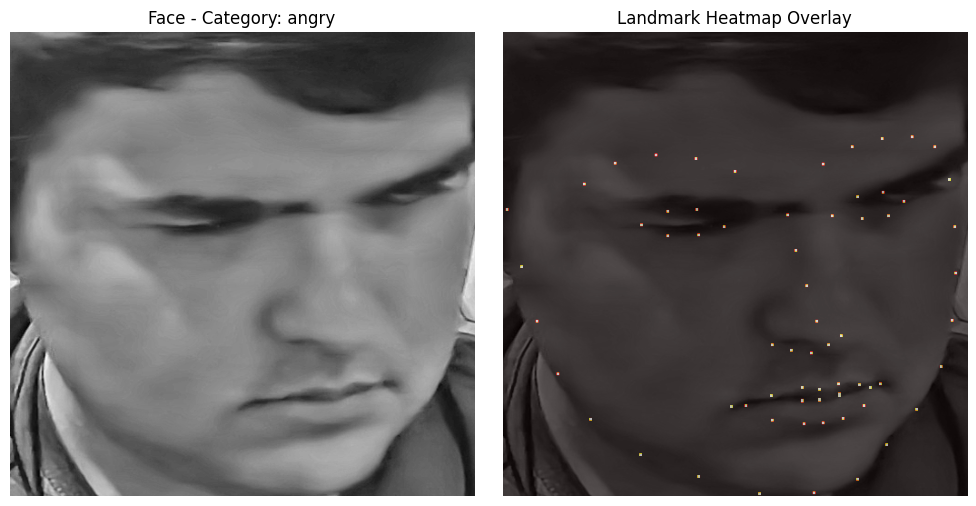

In [25]:
visualize_2_channel_image(training_data, label_map, idx=7)  # Replace idx=0 with the desired image index

### 8. **Custom Dataset y dataloader**

In [26]:
dataset = TwoChannelDataset(training_data)

In [27]:
split_ratio = 0.8
#distancias
dataset_length = len(dataset)  
train_length = int(split_ratio * dataset_length)
test_length = dataset_length - train_length

# Random Split train y test dataset. 
train_dataset, test_dataset = random_split(dataset, [train_length, test_length])

#  DataLoaders  train y test 
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### 9.  Modelo Base

In [28]:
#Util conv2d Kernel tamaño 3
conv_k3 = lambda in_channels, out_channels: nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

In [29]:
channels = 2
channel_1 = 32
channel_2 = 64
resize_input = (512,512)
flattened_size = channel_2 * resize_input[0] * resize_input[1]
out_features=8
epochs = 10
lr = 1e-4

model_base = nn.Sequential(
        conv_k3(channels, channel_2), 
        nn.ReLU(),
        nn.Flatten(),               
        nn.Linear(flattened_size, out_features) )
optimizer = torch.optim.Adam(model_base.parameters(), lr=lr)


In [30]:
_, epochs_h = train(model_base,optimizer, train_loader, epochs,'mps')

Epoch 1/10: 100%|██████████| 15/15 [00:06<00:00,  2.34batch/s, loss=210] 


Epoch 1/10, Loss: 210.3310


Epoch 2/10: 100%|██████████| 15/15 [00:04<00:00,  3.31batch/s, loss=69.6]


Epoch 2/10, Loss: 69.6463


Epoch 3/10: 100%|██████████| 15/15 [00:04<00:00,  3.38batch/s, loss=27.8]


Epoch 3/10, Loss: 27.7655


Epoch 4/10: 100%|██████████| 15/15 [00:04<00:00,  3.40batch/s, loss=17.9]


Epoch 4/10, Loss: 17.8763


Epoch 5/10: 100%|██████████| 15/15 [00:04<00:00,  3.42batch/s, loss=6.3] 


Epoch 5/10, Loss: 6.3010


Epoch 6/10: 100%|██████████| 15/15 [00:04<00:00,  3.44batch/s, loss=2.38] 


Epoch 6/10, Loss: 2.3812


Epoch 7/10: 100%|██████████| 15/15 [00:04<00:00,  3.44batch/s, loss=1.26] 


Epoch 7/10, Loss: 1.2618


Epoch 8/10: 100%|██████████| 15/15 [00:04<00:00,  3.46batch/s, loss=0.662]


Epoch 8/10, Loss: 0.6622


Epoch 9/10: 100%|██████████| 15/15 [00:04<00:00,  3.47batch/s, loss=0.256] 


Epoch 9/10, Loss: 0.2559


Epoch 10/10: 100%|██████████| 15/15 [00:04<00:00,  3.47batch/s, loss=0.316] 

Epoch 10/10, Loss: 0.3163


### 10. Métricas

In [31]:
predictions, true_labels = evaluate(model_base, test_loader, device="mps")

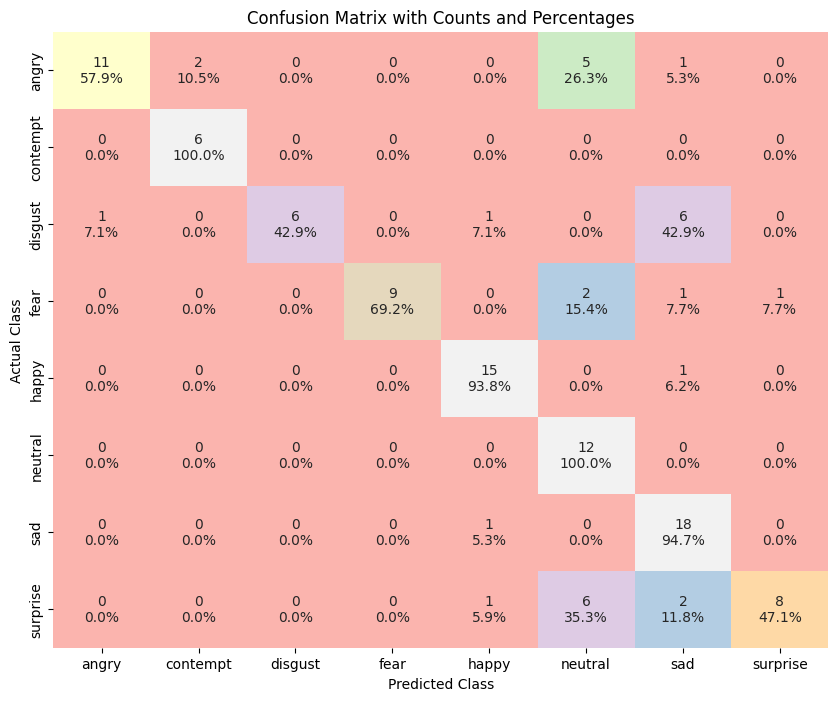

In [32]:
conf_matrix = normal_cm(true_labels, predictions, class_labels=label_names)

#### 10.1 Highlight de Confusion Matrix por Clase

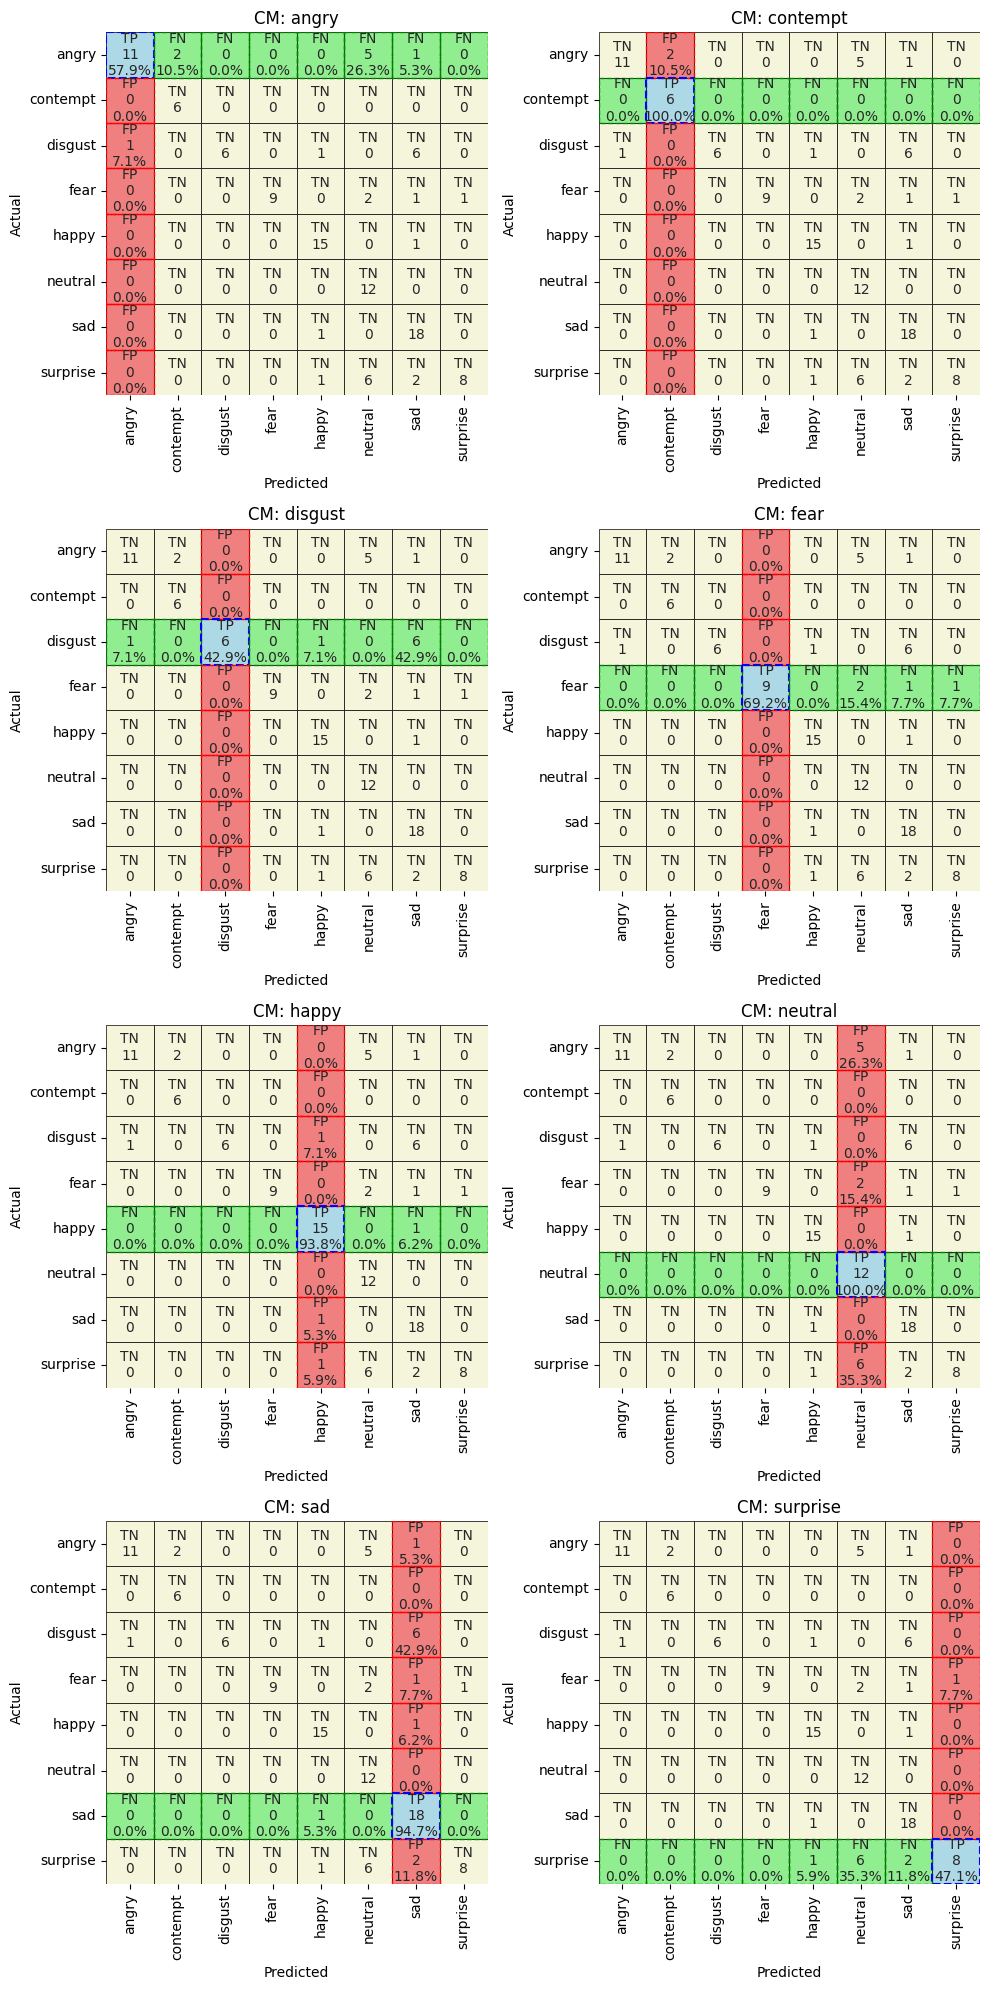

In [33]:
plot_all_class_cm(conf_matrix, label_names, per_row=2)

#### 10.2 Metricas por clase y macros

In [34]:
df_clases, df_macro = compute_classification_metrics(conf_matrix, label_map)
acc = accuracy(predictions,true_labels)
df_macro.loc["Accuracy"] = acc

In [35]:
df_clases

,Recall (Sensitivity),Miss Rate,Specificity (Selectivity),Fallout,Precision,False Discovery Rate (FDR),Negative Predictive Value (NPV),False Omission Rate (FOR),F1 Score
Class,,,,,,,,,
angry,0.578947,0.421053,0.989691,0.010309,0.916667,0.083333,0.923077,0.076923,0.709677
contempt,1.000000,0.000000,0.981818,0.018182,0.750000,0.250000,1.000000,0.000000,0.857143
disgust,0.428571,0.571429,1.000000,0.000000,1.000000,0.000000,0.927273,0.072727,0.600000
fear,0.692308,0.307692,1.000000,0.000000,1.000000,0.000000,0.962617,0.037383,0.818182
happy,0.937500,0.062500,0.970000,0.030000,0.833333,0.166667,0.989796,0.010204,0.882353
neutral,1.000000,0.000000,0.875000,0.125000,0.480000,0.520000,1.000000,0.000000,0.648649
sad,0.947368,0.052632,0.886598,0.113402,0.620690,0.379310,0.988506,0.011494,0.750000
surprise,0.470588,0.529412,0.989899,0.010101,0.888889,0.111111,0.915888,0.084112,0.615385


In [36]:
print(df_macro.to_string())

                                     Valor
Recall (Sensitivity)              0.756910
Miss Rate                         0.243090
Specificity (Selectivity)         0.961626
Fallout                           0.038374
Precision                         0.811197
False Discovery Rate (FDR)        0.188803
Negative Predictive Value (NPV)   0.963394
False Omission Rate (FOR)         0.036606
F1 Score                          0.735174
MCC                               0.694581
Accuracy                         73.275862


#### 10.3 Métricas (ROC&AUC)

In [37]:
preds, true_labs, y_prob = get_predictions_and_probs(model_base, test_loader, "mps")

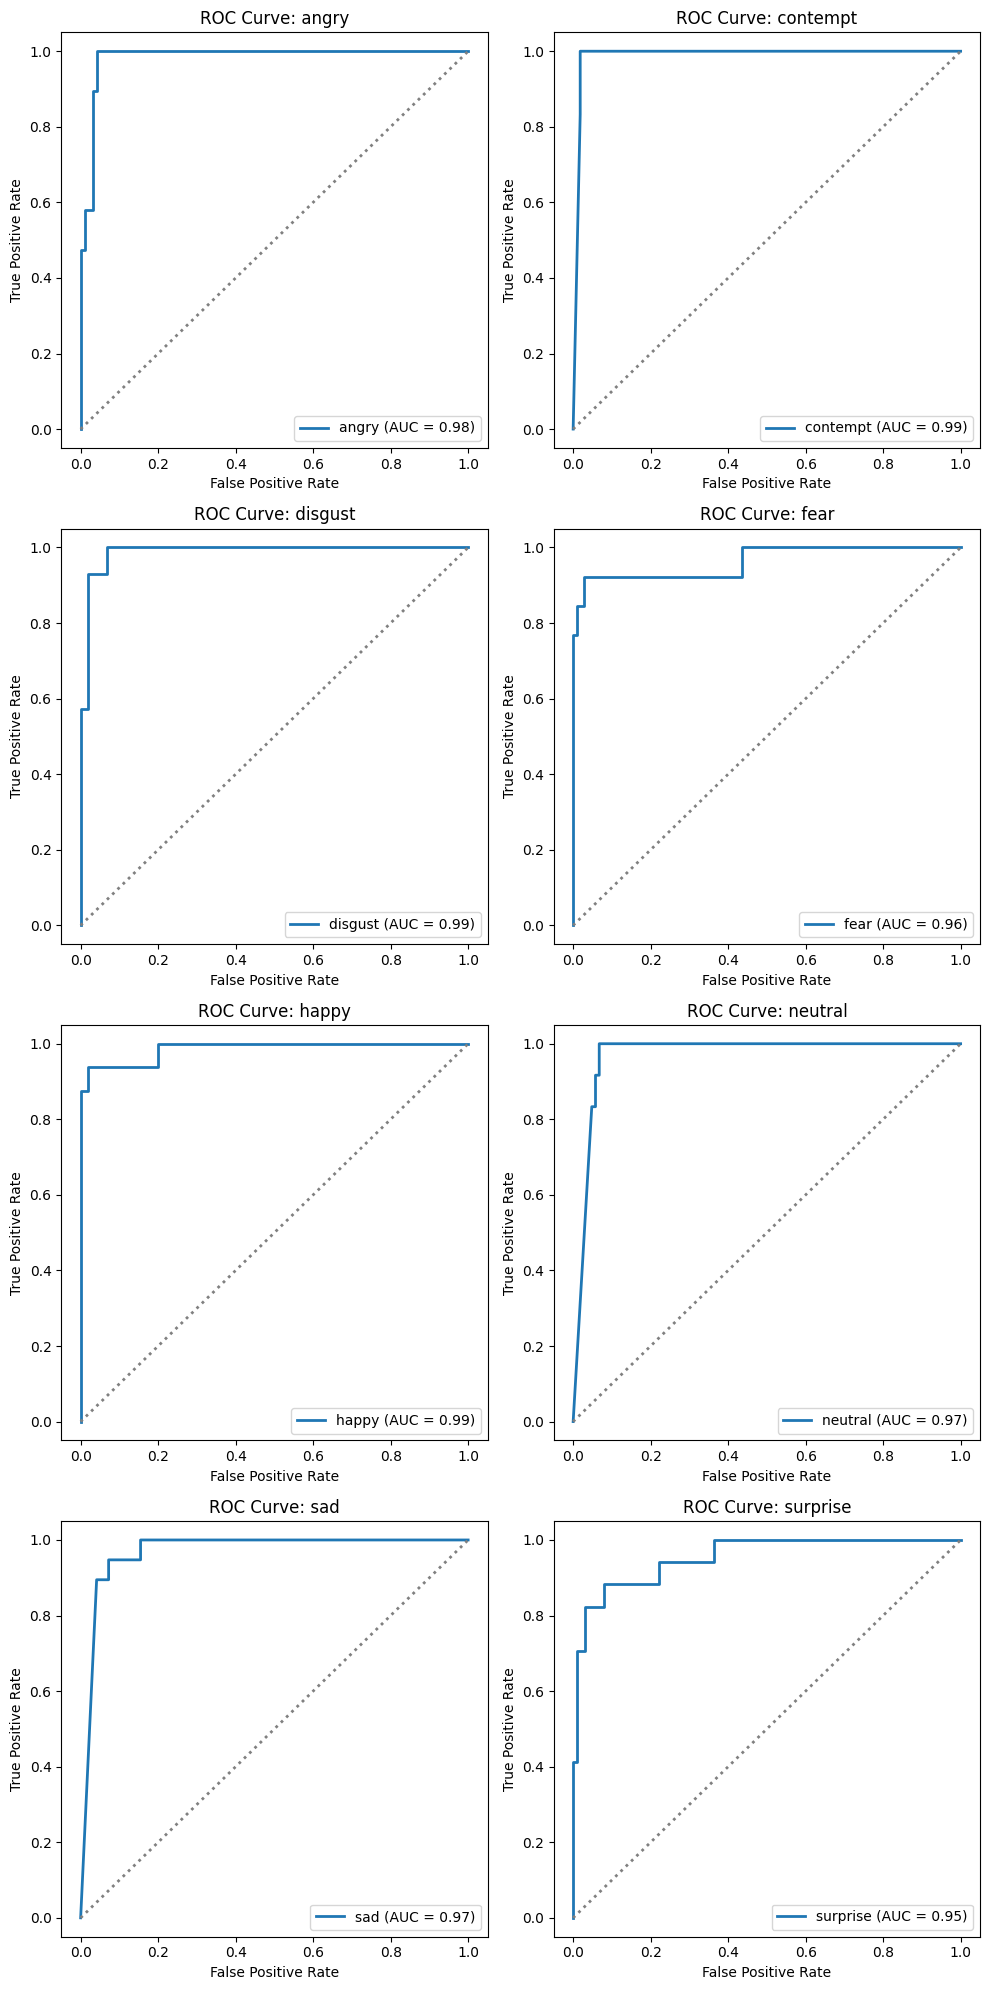

In [38]:
roc_auc_scores = plot_all_class_roc(np.array(true_labels), y_prob, class_names=label_map, per_row=2)

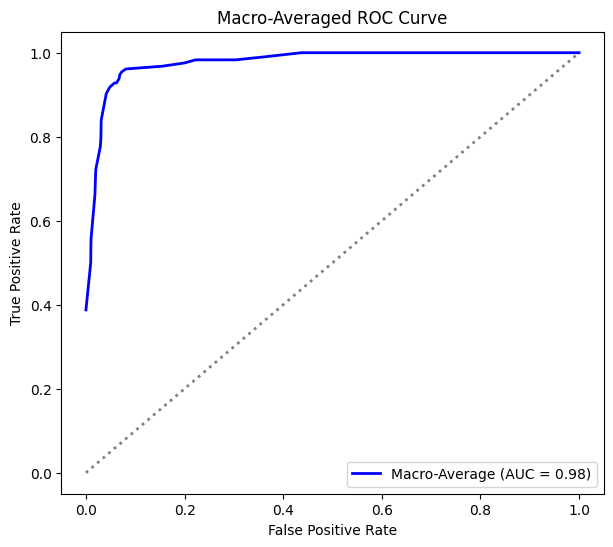

In [39]:
macro_auc = plot_macro_roc(np.array(true_labels), y_prob)

---

# **Análisis** 
## **Construcción de Base line y arreglando sobre ajuste inicial con refinamiento de Datos**
### **Modelo Baseline**
Se definió el siguiente modelo simple como baseline:
- **Arquitectura:**
  ```python
  channels = 2
  channel_2 = 64
  resize_input = (512, 512)
  flattened_size = channel_2 * resize_input[0] * resize_input[1]
  out_features = 8
  epochs = 10
  lr = 1e-4

  model_base = nn.Sequential(
      conv_k3(channels, channel_2), 
      nn.ReLU(),
      nn.Flatten(),
      nn.Linear(flattened_size, out_features)
  )

  optimizer = torch.optim.Adam(model_base.parameters(), lr=lr)
  ```

Este modelo consiste en una capa convolucional con `64` filtros, seguida de una activación ReLU, aplanamiento y una capa completamente conectada que genera `8` salidas (correspondientes a las 8 clases). Se entrenó utilizando Adam con una tasa de aprendizaje de `1e-4` y se ejecutó durante `10` épocas.

---

### **Problema de Sobreajuste**
Qué características afectan significativamente el rendimiento del modelo, áunque en este caso no estamos manejando características en el sentido clásico de variables estructuradas, sí tuvimos que revisar cómo la información de los frames influyen en el modelo, se vio un problema debido a esto. 

Durante la primera iteración, se identifico tarde que los datos que obtuvimos por nuestra cuenta, tenían una  **gran cantidad de redundancia**, lo que resultó en **memorización** en lugar de aprendizaje.
Específicamente, el modelo que planteamos como "baseline" alcanzaba **100% de precisión en entrenamiento**, un sobreajuste extremo.

Para mitigar el problema, se implementaron las siguientes estrategias en este mismo avance:
1. **Mapeo de los bounding boxes de MTCNN a un plano 3D virtual** para calcular un **vector de dirección** de la cabeza.
2. **Filtrado de frames basado en orientación facial:** se restringieron los ángulos de visión dentro de un rango de `-60° a 60°`, garantizando que las imágenes alimentadas al modelo estuvieran dentro de un marco de visión aceptable.
3. **Eliminación de cuadros redundantes:** dentro del rango aceptable y mutable.
4. **Saltos de frames:** se implementó una estrategia de selección inteligente de cuadros, evitando repeticiones innecesarias.
5. **Garantizar diferencia entre frames por grados:** Por ahora cada frame dentro del rango -60/60 tiene una garantía de que tendrá una diferencia de `.2` Este número, idealmente debería ser mayor a 1. e idealmente tendríamos para >2 personas 1920 frames (minimo 1 por cada ángulo) para 8 clases con 2 personas(/960 por persona/120 por clase). Pero la captura de los frames no funciona de manera perfecta. 

---

### **Resultados Antes y Después del Refinamiento de Datos**
- **Antes con el modelo con sobre ajuste:** 
  - Teníamos alrededor de **~5100 frames** distribuidos en **8 clases**.
  - Con un filtrado ineficiente de similitud de posición, quedaban al final, alrededor de **~2000 frames**.
  - El baseline propuesto alcanzaba **100% de precisión**, indicando memorización.

- **Después del refinamiento de datos:**
  - Se redujo la cantidad de datos de **~5100** a **577**.
  - El modelo baseline ahora tiene **67% de precisión**, lo cual es una mejora significativa considerando:
    - La drástica reducción de datos.
    - La eliminación del sobre ajuste extremo.
    - La implementación de filtros más inteligentes para capturar información relevante.
    - La metodología de selección pretende garantizar frames que cuenten con información diferente pero de la misma clase, eliminando repetición. 


---

### Avance 3
El problema tiene **8 clases** por lo menos al momento, y la precisión esperada por azar sería **1/8 = 12.5%**. Al superar esta tasa, diríamos que tenemos **información útil** y que el problema **es abordable** desde un punto de vista de ML.

Antes de aplicar los filtros, el modelo estaba **memorizando** en lugar de aprender. Después de la reducción de datos de **~5100 a 577 frames**, el modelo **logra 67%(73) de precisión** lo que me dice a mí que:
    - Hay patrones y features claros.
    - Se eliminó ruido y redundancia sin comprometer la información y el rendimiento.

La identificación de expresiones faciales es un problema difícil:
   - Depende de **variaciones sutiles en la posición de músculos faciales**.
   - Se ve afectado por **iluminación, ángulos de cámara, diferencias individuales en rostros, etc.**
   - No todas las clases tienen la misma facilidad de reconocimiento. Expresiones neutras o sutiles pueden ser más difíciles de diferenciar, *en mis datos quería evitar la exageración* por lo que algunas expresiones, que podemos ver claramente en las matrices (highlights) que tienen problemas, son los que este primer modelo tiene un poco de problemas. Claro que si volvemos a hacer datos y damos expresiones mucho más exageradas y diferenciadoras, no tengo duda de que este modelo simple no tendría problema absoluto en identificarlas, pero queremos más "naturaleza" si es posible. y por los resultados obtenidos, es posible! 

El modelo actual es **extremadamente simple**:
- Solo tiene **una capa convolucional y una capa lineal**.
- No tiene mecanismos avanzados como **BatchNorm, Dropout, augmentations o más convoluciones**.
- No usa **modelos preentrenados** (ej. ResNet o EfficientNet), que suelen mejorar el rendimiento.
- Se entrenó con **10 épocas y una tasa de aprendizaje básica** (`1e-4`).



### ¿Cuál es la métrica adecuada para este problema de negocio? 
Podríamos decir que precisión es la mejor. No debería haber problemas de balance de clases. Oseá, esperamos algo equitativo y la precisión es valida para ello cuando TODAS las expresiones nos importan de manera igual

### ¿Cuál debería ser el desempeño mínimo a obtener?

En aplicaciones reales de reconocimiento facial, modelos de estado del arte tienen entre 80%-90% de precisión en datasets grandes. Para un sistema en producción, se esperaría al menos 70%-80% de precisión, dependiendo de los datos y la tolerancia al error.

Un desempeño minimo para producción creo que debería ser de 70% a 75% pero depende altamente del tipo de expresiones que se encuentren como aceptables. El problema se vuelve mucho más difícil si consideramos tomar en cuenta la "exageración" o no. Si lo hacemos, el minimo debería ser 80%, los detalles son más identificables entre cada expresión, si no lo hacemos podríamos tener el beneficio de un desempeño minimo de 65%


### **Conclusión**

Un **67% (73% en la ultima prueba) de precisión** es un resultado **razonable** para un baseline en un problema de **identificación de expresiones faciales**. Tenemos que también pensar que lo que nos interesa es velocidad.

En el notebook el calculo de box de mtcnn se hace en este momento con landmarks pero es motivo de pruebas para el calculo de posición 3D en pruebas, cuando no se requiere landmarks es mucho más rapido y la función esta implementada, y al final, como se ve lo que se usa para hacer el calculo final es el box de manera simple. 

El manejo de la imagen también es peculiar y razonable, todo entra dentro de una pipeline singular. Claro al momento de entrenamiento es una cosa pero en respuesta es también importante como se consiguen los datos que necesita el modelo.
y obtener una respuesta aceptable me parece positivo como una iteración, gracias a la pipeline que tenemos y los resultados que nos dio en esta baseline. Podemos decir que tiene valor seguir su evolución como modelo y como 

El refinamiento de los datos de entrada tiene un **impacto crítico** en el rendimiento del modelo. De un catastrófico sobre ajuste, pasamos a algo entendible, y que inclusive podemos entender la dificultad en las clases especificas. Aunque se trata de un modelo baseline, las modificaciones realizadas permiten obtener **una evaluación realista del problema** y establecen un punto de partida más sólido para modelos más complejos y también una posible guia de como alimentar el modelo.

Con más datos, sería mejor reducir el threshold (del ángulo de posición del rostro) de *.2 a .3 o inclusive más pero reduciríamos la cantidad de datos aún más por lo que es necesario incrementar agresivamente los datos raw de video clips.

Si pudiera los incrementaría hasta que el modelo en su construcción baseline no pudiera aprender las diferencias en absoluto.
Una pequeña parte del problema de hacer el dataset mas extenso por mi propia cuenta es que el sistema de limpieza que se implemento es muy robusto y no importa el tipo de posición en la que este, lentes, peinado, ropa o demás, es lo mismo si yo meto más frames propios. Al final soy *yo* si quisiera meter más expresiones *mías* tendrían que ser de las que no quiero hacer "exageradas" para que sean "diferentes" por una parte esta bien si el sistema es solo para una persona, pero veo la "exageración" como un veneno para el sistema. 

Mejorar el sistema fuera de los datos podría ser:
    -  Pasar de 68 a 194 landmarks dándole aún más features claros y detallados.
    -  Tomar la información de ángulos y de alguna forma implementarla a los puntos existentes. 
    -  Eliminar landmarks de cara extra. Hay algunos puntos de los 68 por ejemplo, que realmente no aportan información util al modelo. Como el contorno del rostro. Son solo datos, puntos extras 
    -  Alrededor de `60 frames` por `clase` por persona `480`, deberíamos de apuntar a conseguir `2400` frames procesados  (`5` personas ósea 3 más. y una diferencia de `2` grados en el field view de `-60/60` no `.2`)
    (Que ya están confirmados pero se han tardado en darme los archivos de videos!) 